# Do `source setup.sh` before trying to run this notebook!

## External Imports

In [9]:
import numpy as np; import pandas as pd
import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn
#use numba's just-in-time compiler to speed things up
from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; import matplotlib.pyplot as plt; 
#reset matplotlib stle/parameters
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
font_legend = 15; font_axes=15
# %matplotlib inline
import copy; import sys; import os
from IPython.display import Image, display
from importlib import import_module

try:
    import optuna
except Exception:
    print('optuna is only used for hyperparameter tuning, not critical!')
    pass
import argparse
import time
# import sympy as sy
import ipywidgets as wid; 

In [10]:
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)
#sometimes jupyter doesnt initialize MathJax automatically for latex, so do this
wid.HTMLMath('$\LaTeX$')

HTMLMath(value='$\\LaTeX$')

## Import utils

In [11]:
try:
    IQN_BASE = os.environ['IQN_BASE']
    print('BASE directoy properly set = ', IQN_BASE)
    utils_dir = os.path.join(IQN_BASE, 'utils')
    sys.path.append(utils_dir)
    import utils
    #usually its not recommended to import everything from a module, but we know
    #whats in it so its fine
    from utils import *
    print('DATA directory also properly set, in %s' % os.environ['DATA_DIR'])
except Exception:
    print("""\nBASE directory not properly set. Read repo README.\
    If you need a function from utils, use the decorator below, or add utils to sys.path\n
    You can also do os.environ['IQN_BASE']=<ABSOLUTE PATH FOR THE IQN REPO>""")
    pass

BASE directoy properly set =  /home/ali/Desktop/Pulled_Github_Repositories/torchQN
DATA directory also properly set, in /home/ali/Desktop/Pulled_Github_Repositories/IQN_HEP/Davidson/data


## Set arguments and configurations

In [12]:
################################### ARGUMENTS ###################################
parser=argparse.ArgumentParser(description='train for different targets')
parser.add_argument('--N', type=str, help='size of the dataset you want to use. Options are 10M and 100K and 10M_2, the default is 10M_2', required=False,default='10M_2')
#N_epochs X N_train_examples = N_iterations X batch_size
# N_iterations = (N_epochs * train_data.shape[0])/batch_size
#N_iterations = (N_epochs * train_data.shape[0])/64 = 125000 for 1 epoch
parser.add_argument('--n_iterations', type=int, help='The number of iterations for training, the default is', required=False,default=50)
#default=5000000 )
parser.add_argument('--n_layers', type=int, help='The number of layers in your NN, the default is 5', required=False,default=6)
parser.add_argument('--n_hidden', type=int, help='The number of hidden layers in your NN, the default is 5', required=False,default=6)
parser.add_argument('--starting_learning_rate', type=float, help='Starting learning rate, the defulat is 10^-3', required=False,default=1.e-2)
parser.add_argument('--show_loss_plots', type=bool, help='Boolean to show the loss plots, default is False', required=False,default=False)
parser.add_argument('--save_model', type=bool, help='Boolean to save the trained model dictionary', required=False,default=False)
parser.add_argument('--save_loss_plots', type=bool, help='Boolean to save the loss plots', required=False,default=False)


################################### CONFIGURATIONS ###################################
DATA_DIR=os.environ['DATA_DIR']
JUPYTER=True

if JUPYTER:
    args = parser.parse_args(args=[])
    N = '10M_2'
    n_iterations = int(1e4)
    n_layers, n_hidden = int(1), int(10)
    starting_learning_rate = float(1.e-2)
    show_loss_plots = False
    save_model=False
    save_loss_plots = False
else:
    args = parser.parse_args()
    N = args.N
    n_iterations = args.n_iterations
    n_layers = args.n_layers
    n_hidden = args.n_hidden
    starting_learning_rate=args.starting_learning_rate
    show_loss_plots=args.show_loss_plots
    save_model=args.save_model
    save_loss_plots=args.save_loss_plots

dropout=0.2

def get_model_params():
    return n_iterations, n_layers, n_hidden, starting_learning_rate, dropout

### Import the numpy data, convert to dataframe and save (if you haven't saved the dataframes)

# Explore the Dataframe and preprocess

# idea: do another flowchart for how IQN works autoregressively to get $p_T'$, etc

In [69]:
def show_jupyter_image(image_filename):
    """ Make sure image_filename is in your IQN_BASE !"""
    display(Image(os.path.join(IQN_BASE,image_filename), width = 1300, height = 300  ))
    
    
def use_svg_display():
    """Use the svg format to display a plot in Jupyter (better quality)"""
    from matplotlib_inline import backend_inline
    backend_inline.set_matplotlib_formats('svg')

def reset_plt_params():
    mpl.rcParams.update(mpl.rcParamsDefault)

def show_plot(legend=None):
    use_svg_display()
    plt.tight_layout();
    plt.show()
    if legend:
        plt.legend(loc='best')
    
def set_axes(ax, xlabel, ylabel, xmin, xmax, ymin=None, ymax=None, title=None):
    use_svg_display()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(xmin, xmax)
    
    if ax.get_title()  != '':
        #if the axes does have a title (plot
        ax.set_title(title)
    if ax.legend():
        ax.legend()
    if ymin and ymax:
        ax.set_ylim(ymin, ymax)
        
    plt.show()
    
    

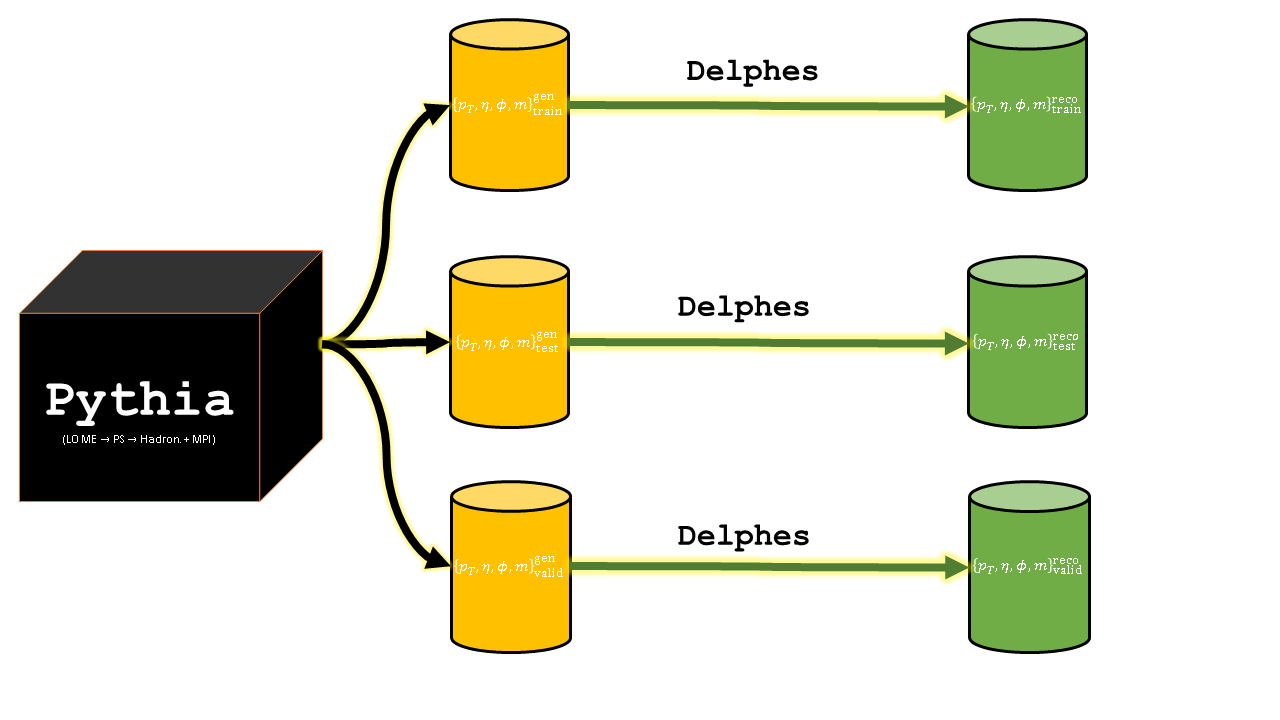

In [70]:
use_svg_display()
show_jupyter_image('data_diagram_IQN.png')

In [71]:
################################### SET DATA CONFIGURATIONS ###################################
X       = ['genDatapT', 'genDataeta', 'genDataphi', 'genDatam', 'tau']

FIELDS  = {'RecoDatam' : {'inputs': X, 
                           'xlabel':  r'$m$ (GeV)', 
                           'xmin': 0, 
                           'xmax': 25},
           
           'RecoDatapT': {'inputs': ['RecoDatam']+X, 
                           'xlabel':  r'$p_T$ (GeV)' , 
                           'xmin'  : 20, 
                           'xmax'  :  80},
           
           'RecoDataeta': {'inputs': ['RecoDatam','RecoDatapT'] + X, 
                           'xlabel': r'$\eta$',
                           'xmin'  : -5,
                           'xmax'  :  5},
           
           'RecoDataphi'  : {'inputs': ['RecoDatam', 'RecodatapT', 'RecoDataeta']+X,
                           'xlabel': r'$\phi$' ,
                           'xmin'  : -3.2, 
                           'xmax'  :3.2}
          }

###############################################################################################
y_label_dict ={'RecoDatapT':'$p(p_T)$'+' [ GeV'+'$^{-1} $'+']',
                    'RecoDataeta':'$p(\eta)$', 'RecoDataphi':'$p(\phi)$',
                    'RecoDatam':'$p(m)$'+' [ GeV'+'$^{-1} $'+']'}

loss_y_label_dict ={'RecoDatapT':'$p_T^{reco}$',
                    'RecoDataeta':'$\eta^{reco}$', 'RecoDataphi':'$\phi^{reco}$',
                    'RecoDatam':'$m^{reco}$'}

In [72]:
all_variable_cols=['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam']
all_cols=['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam', 'tau']
################################### Load unscaled dataframes ###################################
SUBSAMPLE=int(1e4)
train_data=pd.read_csv(os.path.join(DATA_DIR,'train_data_10M_2.csv'),
                      usecols=all_cols,
                      nrows=SUBSAMPLE
                      )

test_data=pd.read_csv(os.path.join(DATA_DIR,'test_data_10M_2.csv'),
                      usecols=all_cols,
                     nrows=SUBSAMPLE
                     )

In [73]:
fig, ax = plt.subplots(1,1)
# ax.set_title('gi')
print(ax.get_title()  != '' )

False


In [78]:
def explore_data(df, title, scaled=False):
    fig, ax = plt.subplots(1,5, figsize=(20,10) )
    # df = df[['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam']]
    levels = ['RecoData', 'genData']
    kinematics=['pT','eta','phi','m']
    columns = [level+k for level in levels for k in kinematics]
    print(columns)
    columns = columns + ['tau']
    print(columns)
    df = df[columns]
    
    for k_i, k in enumerate(kinematics):
        Reco_var = levels[0]+k
        gen_var = levels[1]+k
        print('Reco_var: ', Reco_var, ', \t gen_var: ', gen_var)
        ax[k_i].hist(df[Reco_var], bins=100, label=Reco_var, alpha=0.35)
        ax[k_i].hist(df[gen_var], bins=100, label=gen_var, alpha=0.35)
        xmin, xmax = FIELDS[Reco_var]['xmin'], FIELDS[Reco_var]['xmax']
        xlabel=FIELDS[Reco_var]['xlabel']
        ax[k_i].set_xlim( (xmin, xmax) )
        # set_axes(ax[k_i], xlabel=xlabel, ylabel='', xmin=xmin, xmax=xmax)
        ax[k_i].set_xlabel(xlabel,fontsize=26)
        
        
                  
        if scaled:
            ax[k_i].set_xlim(df[gen_var].min(),df[gen_var].max() )
        
        ax[k_i].legend(loc='best', fontsize=13)
    ax[4].hist(df['tau'],bins=100, label=r'$\tau$')
    ax[4].legend(loc='best', fontsize=13)
    fig.suptitle(title, fontsize=30)
    show_plot()

['RecoDatapT', 'RecoDataeta', 'RecoDataphi', 'RecoDatam', 'genDatapT', 'genDataeta', 'genDataphi', 'genDatam']
Reco_var:  RecoDatapT , 	 gen_var:  genDatapT
Reco_var:  RecoDataeta , 	 gen_var:  genDataeta
Reco_var:  RecoDataphi , 	 gen_var:  genDataphi
Reco_var:  RecoDatam , 	 gen_var:  genDatam


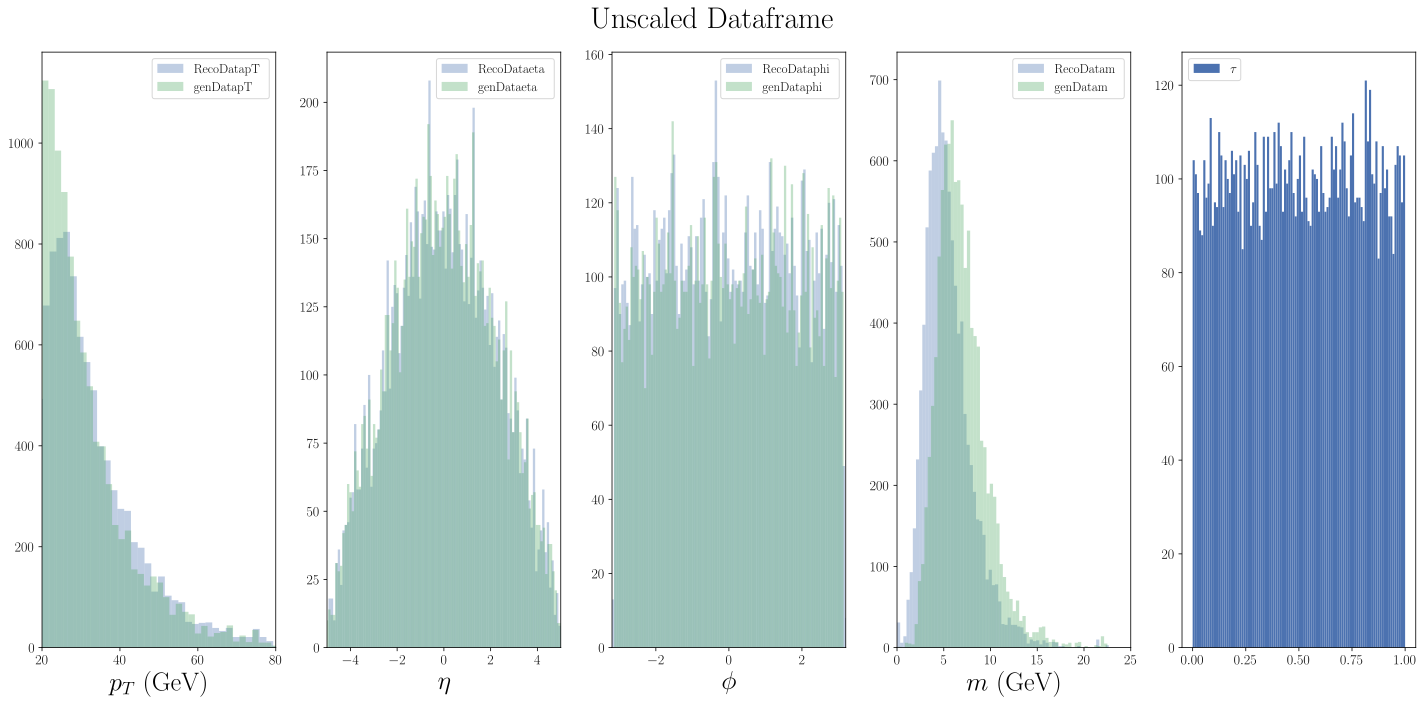

In [79]:
explore_data(df=train_data, title='Unscaled Dataframe')

In [18]:
print(train_data.shape)
train_data.describe()#unscaled

(10000, 9)


,genDatapT,genDataeta,genDataphi,genDatam,RecoDatapT,RecoDataeta,RecoDataphi,RecoDatam,tau
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,32.748727,-0.007169,0.004215,6.980037,32.982230,-0.007198,0.004905,5.531751,0.501375
std,14.374873,2.209883,1.809176,2.751696,15.626337,2.202264,1.809657,2.639882,0.288104
min,20.004600,-5.053690,-3.140890,0.136333,11.532200,-4.936930,-3.351365,-0.000022,0.000014
25%,23.693450,-1.636940,-1.556042,5.119607,23.495425,-1.637945,-1.555673,3.780315,0.252924
50%,28.400000,-0.012826,-0.023519,6.547370,29.017050,-0.018205,-0.023471,5.087130,0.501390
75%,36.486850,1.633903,1.552912,8.363860,37.877825,1.629590,1.557280,6.772220,0.751112
max,183.448000,5.039390,3.140640,35.081300,185.426000,4.998390,3.381455,33.813600,0.999968


standarize: $$ X' = \frac{X-X_{min}}{X_{max}-X_{min}} \qquad \rightarrow \qquad X= X' (X_{max}-X_{min}) + X_{min}$$

In [19]:
def standarize(values):
    expected_min, expected_max = values.min(), values.max()
    scale_factor = expected_max - expected_min
    offset = expected_min
    standarized_values = (values - offset)/scale_factor 
    return standarized_values

standarize_2:
$$ X'=\frac{X-E[X]}{\sigma_{X}}  \qquad \rightarrow \qquad X = X' \sigma_{X} + E[X]$$

In [20]:
def standarize_2(values):
    return values - (np.mean(values)/np.std(values))

## Scale the data accoding to the "Braden Kronheim scaling" :

$$\mathbb{T}(p_T) = z(\log p_T), \qquad \mathbb{T}(\eta) = z(\eta), \qquad \mathbb{T}(\phi) = z(\phi), \qquad \mathbb{T}(m) = z(\log (m + 2)), \qquad  \mathbb{T}(\tau) = 6\tau - 3 $$

In [29]:
def set_figsize(figsize=(7, 7)):
    plt.rcParams['figure.figsize'] = figsize

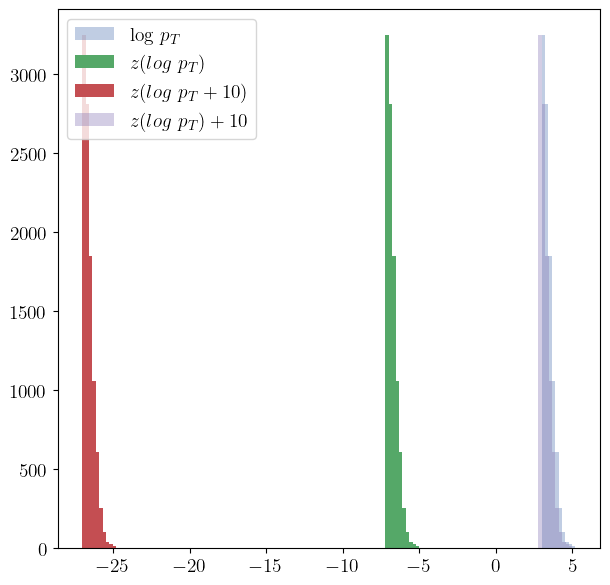

In [30]:
use_svg_display()
set_figsize()
plt.hist(np.log(train_data.iloc[:,0]), label='log $p_T$',alpha=0.35);
plt.hist(standarize_2(np.log(train_data.iloc[:,0])), label='$z(log\ p_T$)');
plt.hist(standarize_2(np.log(train_data.iloc[:,0]) +10), label='$z(log\ p_T + 10$)');
plt.hist(standarize_2(np.log(train_data.iloc[:,0]))+10, label='$z(log\ p_T)+10$',alpha=0.35);
plt.legend();plt.show()

standarize_IQN:
$$ X' = \frac{X-X_{min}}{X_{max}-X_{min}} \qquad \rightarrow \qquad X= X' (X_{max}-X_{min}) + X_{min}$$

Standarize_IQN_2:
$$ p_T' = \frac{\log p_T - E[\log p_T] }{\sigma_{\log p_T}} + 10 \qquad \rightarrow \qquad p_T = \text{exp} \left((p_T' - 10) \sigma_{\log p_T} + E[\log p_T] \right)$$

In [70]:
# def standarize_IQN(values, label, const):
    

In [71]:
def scale_df(df, title, scale_func, save=False):
    #scale
    SUBSAMPLE=int(1e4)
    df = df[all_cols]#[:SUBSAMPLE]
    # print(df.head())
    scaled_df = pd.DataFrame()
    #select the columns by index: 
    # 0:genDatapT, 1:genDataeta, 2:genDataphi, 3:genDatam, 
    # 4:RecoDatapT, 5:RecoDataeta, 6:RecoDataphi, 7: Recodatam
    scaled_df['genDatapT'] = scale_func(np.log(df.iloc[:,0]) )
    scaled_df['RecoDatapT'] = scale_func(np.log(df.iloc[:,4]) )
    
    scaled_df['genDataeta'] = scale_func(df.iloc[:,1])
    scaled_df['RecoDataeta'] = scale_func(df.iloc[:,5])
    
    
    scaled_df['genDataphi'] = scale_func(df.iloc[:,2])
    scaled_df['RecoDataphi'] = scale_func(df.iloc[:,6])

    scaled_df['genDatam'] = scale_func(np.log(df.iloc[:,3] + 2) )
    scaled_df['RecoDatam'] = scale_func(np.log(df.iloc[:,7] + 2) )
    #why scale tau?
    # scaled_df['tau'] = 6 * df.iloc[:,8] - 3
    scaled_df['tau'] = df.iloc[:,8]
    
    print(scaled_df.describe())
    
    if save:
        scaled_df.to_csv(os.path.join(DATA_DIR, title) )
    return scaled_df

          genDatapT    RecoDatapT    genDataeta   RecoDataeta    genDataphi  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.193019      0.349439      0.499998      0.496183      0.500691   
std        0.151402      0.137091      0.218950      0.221660      0.288015   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.076371      0.256223      0.338524      0.332046      0.252303   
50%        0.158137      0.332218      0.499438      0.495075      0.496276   
75%        0.271209      0.428161      0.662592      0.660927      0.747239   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

        RecoDataphi      genDatam     RecoDatam           tau  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       0.498494      0.488433      0.440818      0.501375  
std        0.268781      0.100227      0.113154      0.288104  
min        0.000000      0.00000

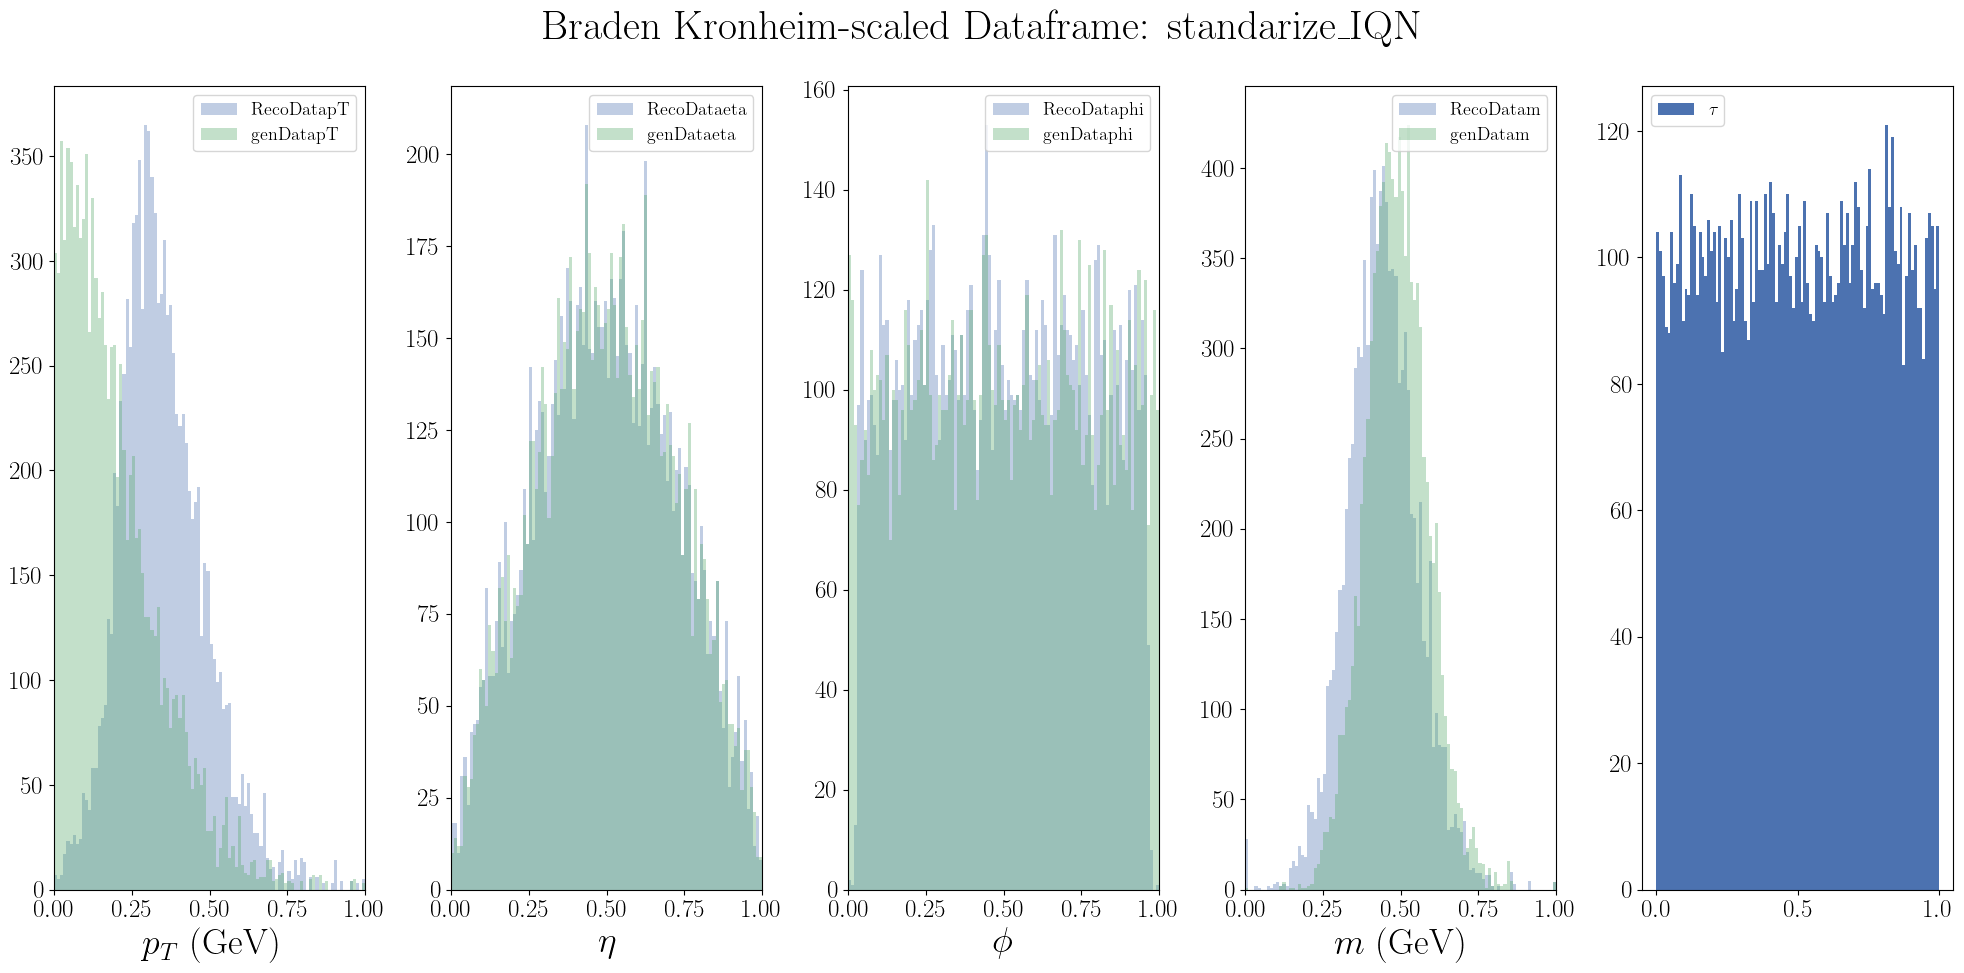

In [74]:
scaled_train_data = scale_df(train_data, title='scaled_train_data_10M_2.csv',
                             scale_func=standarize,
                             save=False)
print('\n\n')
scaled_test_data = scale_df(test_data,  title='scaled_test_data_10M_2.csv',
                            scale_func=standarize,
                            save=False)

explore_data(df=scaled_train_data, title='Braden Kronheim-scaled Dataframe: standarize_IQN', scaled=True)

          genDatapT    RecoDatapT    genDataeta   RecoDataeta    genDataphi  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      -6.781494     -5.555223     -0.003925     -0.003929      0.001885   
std        0.335502      0.380772      2.209883      2.202264      1.809176   
min       -7.209217     -6.525794     -5.050446     -4.933662     -3.143220   
25%       -7.039981     -5.814132     -1.633696     -1.634677     -1.558373   
50%       -6.858790     -5.603054     -0.009582     -0.014936     -0.025849   
75%       -6.608227     -5.336572      1.637147      1.632858      1.550582   
max       -4.993248     -3.748282      5.042634      5.001658      3.138310   

        RecoDataphi      genDatam     RecoDatam           tau  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       0.002195     -5.374291     -4.054152      0.501375  
std        1.809657      0.286049      0.326472      0.288104  
min       -3.354076     -6.76829

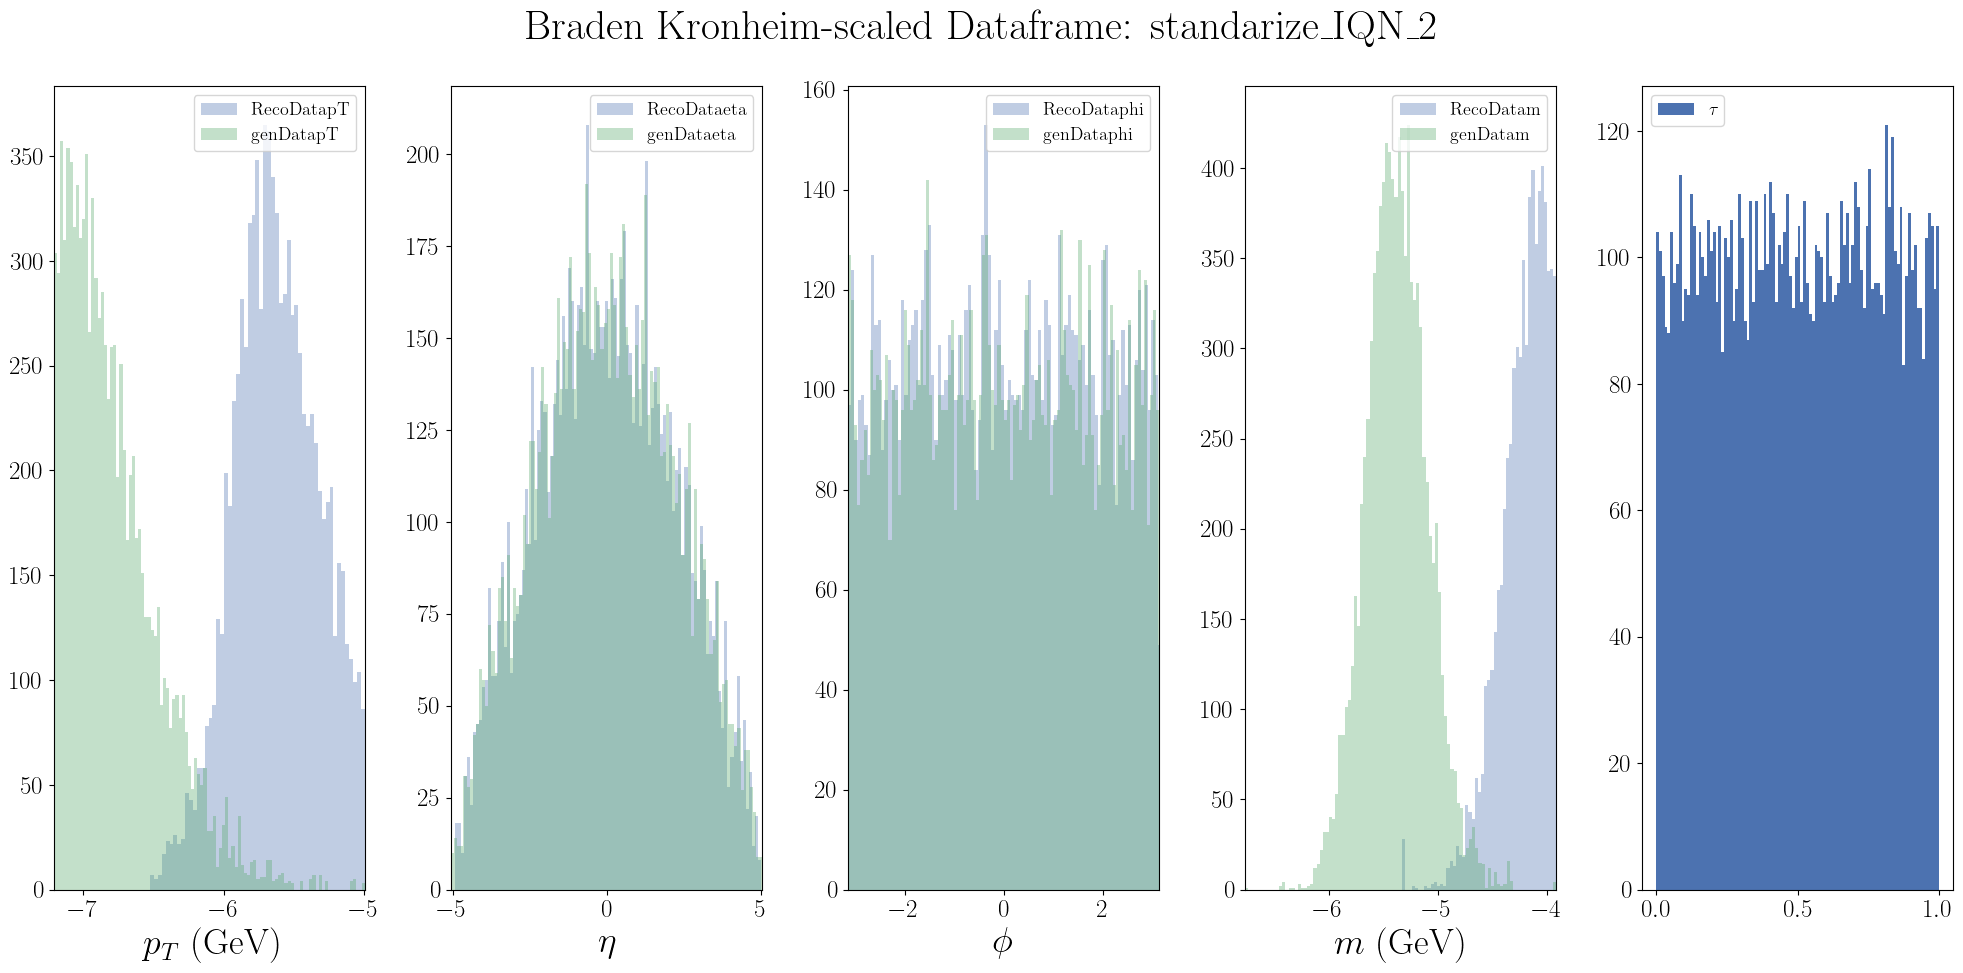

In [75]:
scaled_train_data = scale_df(train_data, title='scaled_train_data_10M_2.csv',
                             scale_func=standarize_2,
                             save=False)
print('\n\n')
scaled_test_data = scale_df(test_data,  title='scaled_test_data_10M_2.csv',
                            scale_func=standarize_2,
                            save=False)

explore_data(df=scaled_train_data, title='Braden Kronheim-scaled Dataframe: standarize_IQN_2', scaled=True)

### standarize is better than standarize_2

          genDatapT    RecoDatapT    genDataeta   RecoDataeta    genDataphi  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.193019      0.349439      0.499998      0.496183      0.500691   
std        0.151402      0.137091      0.218950      0.221660      0.288015   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.076371      0.256223      0.338524      0.332046      0.252303   
50%        0.158137      0.332218      0.499438      0.495075      0.496276   
75%        0.271209      0.428161      0.662592      0.660927      0.747239   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

        RecoDataphi      genDatam     RecoDatam           tau  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       0.498494      0.488433      0.440818      0.501375  
std        0.268781      0.100227      0.113154      0.288104  
min        0.000000      0.00000

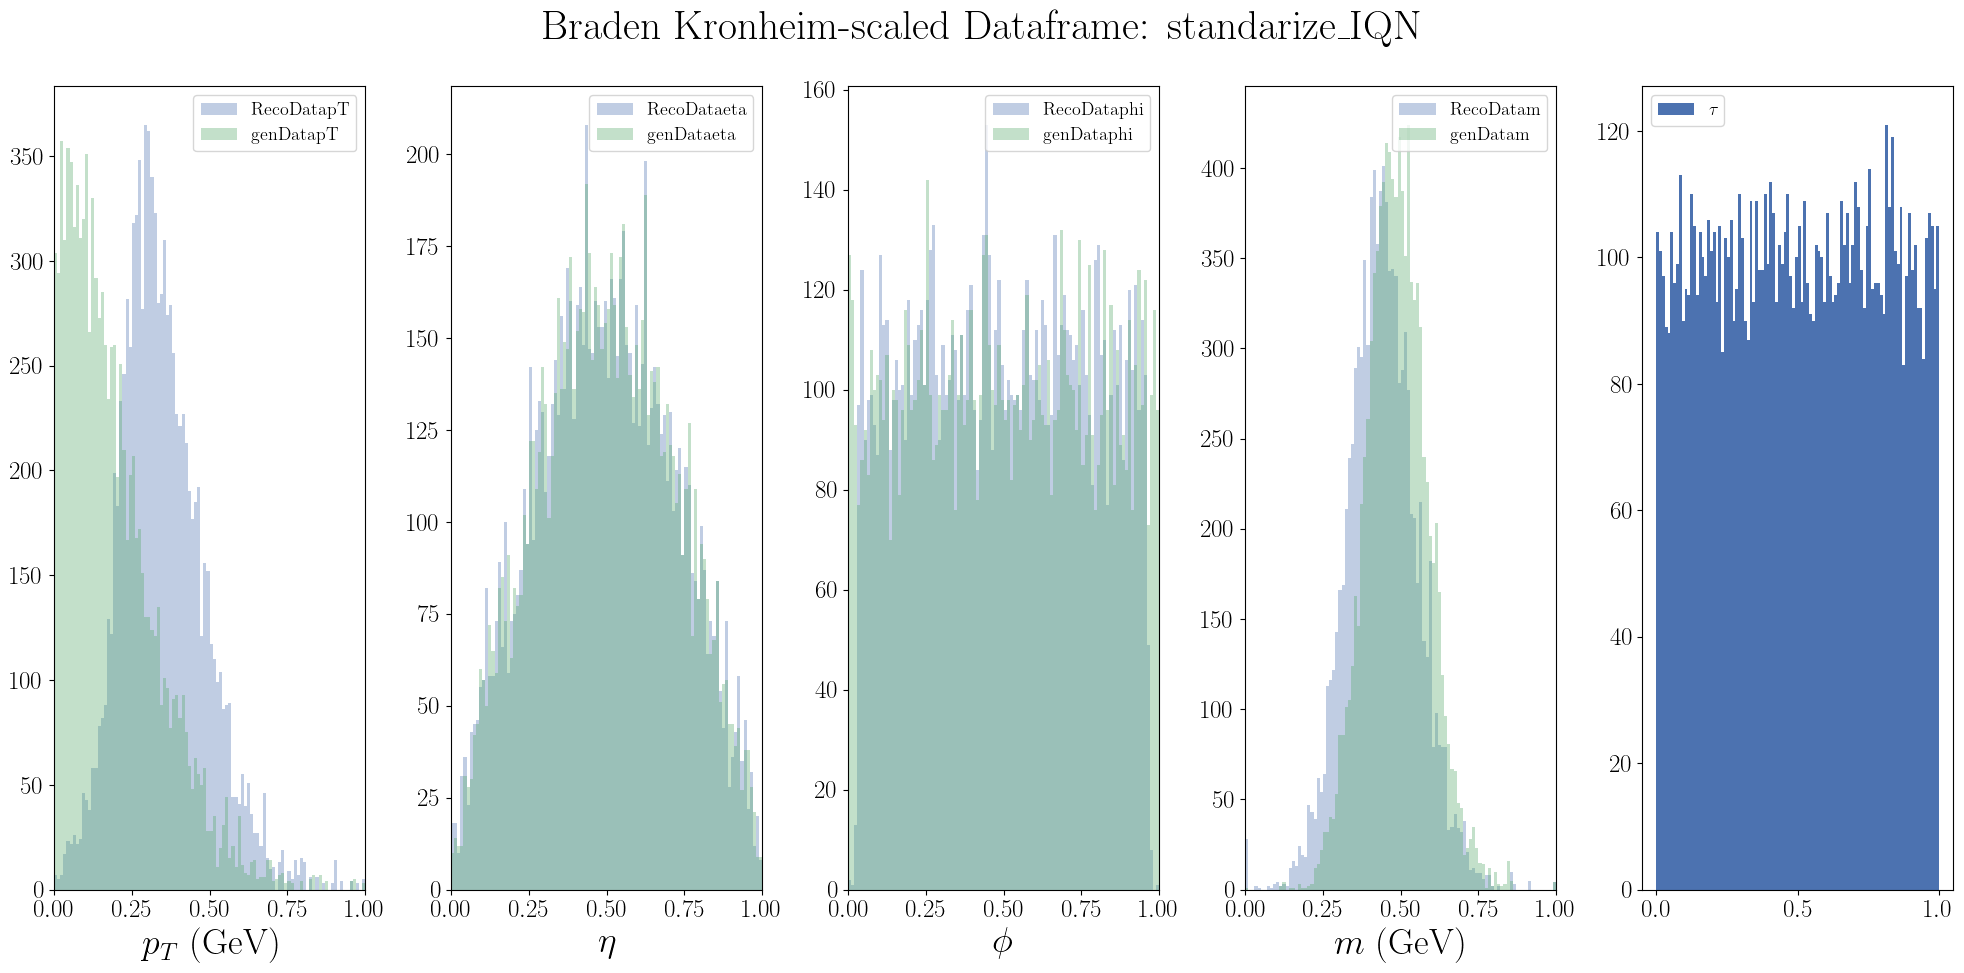

In [76]:
scaled_train_data = scale_df(train_data, title='scaled_train_data_10M_2.csv',
                             scale_func=standarize,
                             save=True)
print('\n\n')
scaled_test_data = scale_df(test_data,  title='scaled_test_data_10M_2.csv',
                            scale_func=standarize,
                            save=True)

explore_data(df=scaled_train_data, title='Braden Kronheim-scaled Dataframe: standarize_IQN', scaled=True)

In [46]:
def denormalize_IQN(original_values, scaled_values):
    expected_min, expected_max = original_values.min(), original_values.max()
    scale_factor = expected_max - expected_min
    offset = expected_min
    return scaled_values  * scale_factor + offset

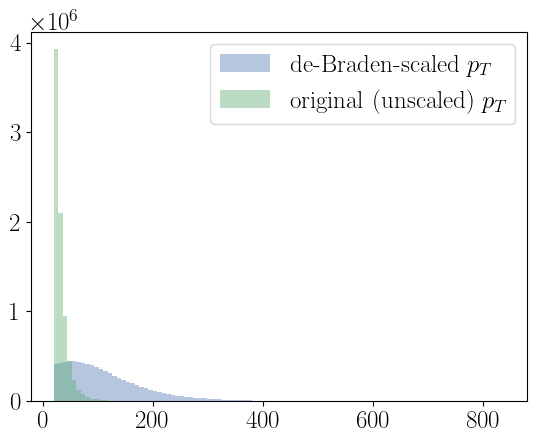

In [29]:
de_scaled_m = denormalize_IQN(original_values=train_data.iloc[:,0], scaled_values=scaled_train_data.iloc[:,0])
plt.hist(de_scaled_m,bins=100, label='de-Braden-scaled $p_T$',alpha=0.4)
plt.hist(train_data.iloc[:,0],bins=100,label='original (unscaled) $p_T$',alpha=0.4)
plt.legend();plt.show()

---------
------
# ML

according to the [previous paper](https://arxiv.org/pdf/2111.11415.pdf) this method already works for a single IQN.

It's important to remember "the master formula" of all of machine learning:

$$\int \frac{\partial L}{\partial f} p(y|x) dy  = 0 \tag{1}$$

or, equivalently, 

$$ \frac{\delta R}{\delta f}=0,$$

where $L$ is the loss function, $f$ is the model (in this case IQN) (implicitly parameterized by potentially a  gazillion parameters), $y$ is the target(s) that we want to estimate, $x$ is the (set of) training features, $R$ is the risk functional.


So, for IQNs,

$$ L_{\text{IQN}}(f, y)=\left\{\begin{array}{ll}
\tau(y-f(\boldsymbol{x}, \tau ; \boldsymbol{\theta})) & y \geq f(\boldsymbol{x}, \tau ; \boldsymbol{\theta}) \\
(1-\tau)(f(\boldsymbol{x}, \tau ; \boldsymbol{\theta})-y) & y<f(\boldsymbol{x}, \tau ; \boldsymbol{\theta})
\end{array},\right. \tag{2}$$

Means that what was done previously is that the risk functional, which is generally a functional of many models $f$, was a only a functional of a single model: $R[f_1,..., f_n] = f[f_1]$. Here we have 4 models 

$$R_{\text{IQN}x4} =R_{\text{IQN}}[f_m, f_{p_T}, f_\eta, f_\phi], $$ 

and since we're choosing the evaluation order:

$$
\begin{aligned}
    p(\mathbf{y} | \mathbf{x}) & = 
    p(m'|\mathbf{x} )\nonumber\\
    & \times p(p_T'|\mathbf{x}, m' )\nonumber\\
    & \times p(\eta'| \mathbf{x}, m', p_T' )\nonumber\\
      & \times p(\phi' |  \mathbf{x}, m', p_T', \eta' ) ,
\end{aligned}
\tag{3}
$$



$$ \begin{aligned}
R_{\text{IQN}x4} &= \int L_\text{IQN} \left( f_m (\mathbf{x_m},\tau), \mathbf{y_m} \right) p(\mathbf{x_m, y_m})  d \mathbf{x_m} d \mathbf{y_m} \\
&\times \  ... \times \\ 
&\times \int L_\text{IQN} \left( f_\phi (\mathbf{x_\phi},\tau), \mathbf{y_\phi} \right) p(\mathbf{x_\phi, y_\phi})  d \mathbf{x_\phi} d \mathbf{y_\phi}
\end{aligned},\tag{4}$$

where, again, each model $f_i$ is also dependent on a set of parameters $\theta_i$ (dropped for simplicity)

Our risk functional is minimized for

$$\frac{\delta R_{\text{IQN}x4} }{\delta f_m}=0\tag{5}$$

(which is basically what's done in the training process to get $f_m^{*}$ whose weights/parameters minimize the loss). Suppose we factorize the risk as

$$ R_{\text{IQN}x4}  = R_{\text{IQN}}^m \ R_{\text{IQN}}^{p_T}  \ R_{\text{IQN}}^\eta \ R_{\text{IQN}}^\phi \tag{6},$$ 

then, by Eq (4),

$$R_{\text{IQN}}^m \equiv \int L_\text{IQN} \left( f_m (\mathbf{x_m},\tau), \mathbf{y_m} \right) p(\mathbf{x_m, y_m,\tau})  d \mathbf{x_m} d \mathbf{y_m} d \mathbf{\tau},
$$
and by Eq (5)
$$\int d \mathbf{x_m} d \mathbf{y_m} d \mathbf{\tau} \ p(\mathbf{x_m, y_m,\tau})   \ \frac{ \delta L_\text{IQN} \left( f_m (\mathbf{x_m},\tau), \mathbf{y_m} \right) }{\delta f_m} = 0$$

and by Eq (2)

$$
\int d \mathbf{x_m} d \mathbf{y_m} d \mathbf{\tau} \ p(\mathbf{x_m, y_m,\tau})   \ \frac{ \delta L_\text{IQN} \left( f_m (\mathbf{x_m},\tau), \mathbf{y_m} \right) }{\delta f_m} = 0 \tag{7}
$$
>> ...
<br>

Expand Eq (2) in Eq (7) and integrate wrt y to see that  $f(\mathbf{x},\mathbf{\tau})$ is the quantile function for $p(\mathbf{y}|\mathbf{x})$, i.e. that IQNx4 should work.

$$R_{\text{IQN}x4} = [ L \left( f_m( \{ p_T^{\text{gen}}, \eta^{\text{gen}}, \phi^{\text{gen}}, m^{\text{gen}} , \tau \}, m^\text{reco} ) $$
# Train Mass

for mass, $\mathbf{y_m}=m_{\text{reco}}$ and $\mathbf{x_m}=\{p_T^{\text{gen}}, \eta^{\text{gen}}, \phi^{\text{gen}}, m^{\text{gen}} , \tau \}$.


In [151]:
SUBSAMPLE=int(1e4)
target = 'RecoDatam'
source  = FIELDS[target]
features= source['inputs']
########

print('USING NEW DATASET\n')
#UNSCALED
# train_data_m=pd.read_csv(os.path.join(DATA_DIR,'train_data_10M_2.csv'),
#                        usecols=features,
#                        nrows=SUBSAMPLE)

# print('TRAINING FEATURES\n', train_data.head())

# test_data_m= pd.read_csv(os.path.join(DATA_DIR,'test_data_10M_2.csv'),
#                        usecols=features,
#                        nrows=SUBSAMPLE)
# print('\nTESTING FEATURES\n', test_data.head())
# valid_data= pd.read_csv(os.path.join(DATA_DIR,'valid_data_10M_2.csv'),
#                        usecols=features,
#                        nrows=SUBSAMPLE)


# SCALED
train_data_m=pd.read_csv(os.path.join(DATA_DIR,'train_data_10M_2.csv'),
                       usecols=all_cols,
                       nrows=SUBSAMPLE)

print('TRAINING FEATURES\n', train_data.head())

test_data_m= pd.read_csv(os.path.join(DATA_DIR,'test_data_10M_2.csv'),
                       usecols=all_cols,
                       nrows=SUBSAMPLE)
print('\nTESTING FEATURES\n', test_data.head())

print('\ntrain set shape:',  train_data.shape)
print('\ntest set shape:  ', test_data.shape)
# print('validation set shape:', valid_data.shape)

USING NEW DATASET

TRAINING FEATURES
    genDatapT  genDataeta  genDataphi  genDatam  RecoDatapT  RecoDataeta  \
0    29.4452    0.828187    2.902130   2.85348     31.9132     0.817082   
1    24.3193   -1.163510    0.636469   5.83685     27.3513    -1.151020   
2    24.3193   -1.163510    0.636469   5.83685     27.3513    -1.151020   
3    24.3193   -1.163510    0.636469   5.83685     27.3513    -1.151020   
4    20.1703    1.844410   -0.186685   5.69090     24.2158     1.837910   

   RecoDataphi  RecoDatam       tau  
0     2.919510    2.59587  0.361310  
1     0.652153    5.35538  0.126899  
2     0.652153    5.35538  0.962307  
3     0.652153    5.35538  0.457282  
4    -0.160621    4.59370  0.840862  

TESTING FEATURES
    genDatapT  genDataeta  genDataphi  genDatam  RecoDatapT  RecoDataeta  \
0    43.6113    0.824891    -1.26949   5.93310     44.3274     0.824645   
1    43.6113    0.824891    -1.26949   5.93310     44.3274     0.824645   
2    26.0153    3.529970     1.55495   

### Batches, validation, losses, and plotting of losses functions

In [177]:
def get_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return (batch_x, batch_t)

# Note: there are several average loss functions available 
# in pytorch, but it's useful to know how to create your own.
def average_quadratic_loss(f, t, x):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

def average_cross_entropy_loss(f, t, x):
    # f and t must be of the same shape
    loss = torch.where(t > 0.5, torch.log(f), torch.log(1 - f))
    return -torch.mean(loss)

def average_quantile_loss(f, t, x):
    # f and t must be of the same shape
    tau = x.T[-1] # last column is tau.
    return torch.mean(torch.where(t >= f, 
                                  tau * (t - f), 
                                  (1 - tau)*(f - t)))

# function to validate model during training.
def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x)


def mkdir(dir_):
    """make a directory without overwriting what's in it if it exists"""
    # assert isinstance(dir_, str)
    try:
        os.system('mkdir -p %s' % str(dir_) )
    except Exception:
        pass


def plot_average_loss(traces, ftsize=18,save_loss_plots=False, show_loss_plots=True):
    
    xx, yy_t, yy_v, yy_v_avg = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(6, 4.5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss")
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')
    #ax.plot(xx, yy_v_avg, 'g', lw=2, label='Running average')

    ax.set_xlabel('Iterations', fontsize=ftsize)
    ax.set_ylabel('average loss', fontsize=ftsize)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')
    if save_loss_plots:
        filename='IQNx4_%s_Loss.dict' % target 
        mkdir('images/loss_plots')
        PATH = os.path.join(IQN_BASE, 'images', 'loss_plots', filename)
        plt.savefig('images/loss_curves/IQN_'+N+T+'_Consecutive_2.png')
        print('\nloss curve saved in images/loss_curves/IQN_'+N+target+'_Consecutive.png')
    if show_loss_plots:
        plt.show()

### Get training and testing features and targets

In [178]:
target = 'RecoDatam'
source  = FIELDS[target]
features= source['inputs']
################################################
def split_t_x(df, target, input_features):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = np.array(df[target])
    x = np.array(df[input_features])
    return t, x

print(f'spliting data for {target}')
train_t, train_x = split_t_x(df= train_data_m, target = target, input_features=features)
print('train_t shape = ',train_t.shape , 'train_x shape = ', train_x.shape)
print('\n Training features:\n')
print(train_x)
valid_t, valid_x = split_t_x(df= test_data_m, target = target, input_features=features)
print('valid_t shape = ',valid_t.shape , 'valid_x shape = ', valid_x.shape)

print('no need to train_test_split since we already have the split dataframes')

spliting data for RecoDatam
train_t shape =  (10000,) train_x shape =  (10000, 5)

 Training features:

[[29.4452      0.828187    2.90213     2.85348     0.36130954]
 [24.3193     -1.16351     0.636469    5.83685     0.12689925]
 [24.3193     -1.16351     0.636469    5.83685     0.96230681]
 ...
 [36.0059      3.537       3.1117      7.61186     0.30763637]
 [36.0059      3.537       3.1117      7.61186     0.83365051]
 [31.3881      2.70158     0.267685    9.22485     0.89913462]]
valid_t shape =  (10000,) valid_x shape =  (10000, 5)
no need to train_test_split since we already have the split dataframes


### Training and running of training functions

In [179]:
def train(model, optimizer, avloss, getbatch,
          train_x, train_t, 
          valid_x, valid_t,
          batch_size, 
          n_iterations, traces, 
          step=10, window=10):
    
    # to keep track of average losses
    xx, yy_t, yy_v, yy_v_avg = traces
    
    n = len(valid_x)
    
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        batch_x, batch_t = getbatch(train_x, train_t, batch_size)
        
        # convert the numpy arrays batch_x and batch_t to tensor 
        # types. The PyTorch tensor type is the magic that permits 
        # automatic differentiation with respect to parameters. 
        # However, since we do not need to take the derivatives
        # with respect to x and t, we disable this feature
        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()      

        # compute the output of the model for the batch of data x
        # Note: outputs is 
        #   of shape (-1, 1), but the tensor targets, t, is
        #   of shape (-1,)
        # In order for the tensor operations with outputs and t
        # to work correctly, it is necessary that they have the
        # same shape. We can do this with the reshape method.
        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t, x)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, valid_x[:n], valid_t[:n])
            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
            # compute running average for validation data
            len_yy_v = len(yy_v)
            if   len_yy_v < window:
                yy_v_avg.append( yy_v[-1] )
            elif len_yy_v == window:
                yy_v_avg.append( sum(yy_v) / window )
            else:
                acc_v_avg  = yy_v_avg[-1] * window
                acc_v_avg += yy_v[-1] - yy_v[-window-1]
                yy_v_avg.append(acc_v_avg / window)
                        
            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], yy_t[-1], yy_v[-1]))
            else:
                xx.append(xx[-1] + step)
                    
                print("\r%10d\t%10.6f\t%10.6f\t%10.6f" % \
                          (xx[-1], yy_t[-1], yy_v[-1], yy_v_avg[-1]), 
                      end='')
            
    print()      
    return (xx, yy_t, yy_v, yy_v_avg)


def run(model, target, 
        train_x, train_t, 
        valid_x, valid_t, traces,
        n_batch=256, 
        n_iterations=n_iterations, 
        traces_step=500, 
        traces_window=500,
        save_model=False):

    learning_rate= starting_learning_rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    #starting at 10^-3	    
    traces = train(model, optimizer, 
                      average_quantile_loss,
                      get_batch,
                      train_x, train_t, 
                      valid_x, valid_t,
                      n_batch, 
                  n_iterations,
                  traces,
                  step=traces_step, 
                  window=traces_window)
    
    # learning_rate=learning_rate/10
    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    # #10^-4
    # traces = train(model, optimizer, 
    #                   average_quantile_loss,
    #                   get_batch,
    #                   train_x, train_t, 
    #                   valid_x, valid_t,
    #                   n_batch, 
    #               n_iterations,
    #               traces,
    #               step=traces_step, 
    #               window=traces_window)


    # learning_rate=learning_rate/100
    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    # #10^-6
    # traces = train(model, optimizer, 
    #                   average_quantile_loss,
    #                   get_batch,
    #                   train_x, train_t, 
    #                   valid_x, valid_t,
    #                   n_batch, 
    #               n_iterations,
    #               traces,
    #               step=traces_step, 
    #               window=traces_window)

    plot_average_loss(traces)

    if save_model:
        filename='Trained_IQNx4_%s_%sK_iter.dict' % (target, str(int(n_iterations/1000)) )
        PATH = os.path.join(IQN_BASE, 'trained_models', filename)
        torch.save(model.state_dict(), PATH)
        print('\ntrained model dictionary saved in %s' % PATH)
    #utils.ModelHandler(model, scalers)
    return  model

### Define basic NN model

In [180]:
class RegularizedRegressionModel(nn.Module):
    #inherit from the super class
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size, dropout):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layers.append(nn.Linear(nfeatures, hidden_size))
                #batch normalization
                layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                layers.append(nn.Dropout(dropout))
                #ReLU activation 
                layers.append(nn.ReLU())
            else:
                #if this is not the first layer (we dont have layers)
                layers.append(nn.Linear(hidden_size, hidden_size))
                layers.append(nn.BatchNorm1d(hidden_size))
                #Dropout seems to worsen model performance
                # layers.append(nn.Dropout(dropout))
                layers.append(nn.ReLU())
                #output layer:
        layers.append(nn.Linear(hidden_size, ntargets)) 

        # only for classification add sigmoid
        # layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)

    
    def forward(self, x):
        return self.model(x)

In [181]:
n_iterations, n_layers, n_hidden, starting_learning_rate, dropout = get_model_params()

NFEATURES=train_x.shape[1]
model=RegularizedRegressionModel(nfeatures=NFEATURES, ntargets=1,
                           nlayers=n_layers, hidden_size=n_hidden, dropout=dropout)

print(model)

RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)


### Run training

Training for 10000 iterations
estimating RecoDatam

Iteration vs average loss
 iteration	 train-set	 valid-set
         0	  4.042081	  4.107997
      9950	  0.490166	  0.486542	  0.493084


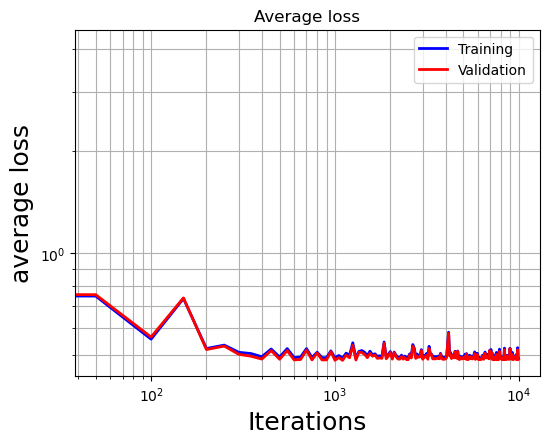

In [182]:
print(f'Training for {n_iterations} iterations')
start=time.time()
print('estimating %s\n' % target)
IQN_trace=([], [], [], [])
traces_step = 50
IQN = run(model=model, target=target,train_x=train_x, train_t=train_t, 
        valid_x=valid_x, valid_t=valid_t, traces=IQN_trace, n_batch=256, 
        n_iterations=n_iterations, traces_step=50, traces_window=50,
        save_model=False)

end=time.time()
difference=end-start
print('evaluating m took ',difference, 'seconds')

In [ ]:
if target== 'RecoDatapT':
    label= '$p_T$ [GeV]'
    x_min, x_max = 20, 60
elif target== 'RecoDataeta':
    label = '$\eta$'
    x_min, x_max = -5.4, 5.4
elif target =='RecoDataphi':
    label='$\phi$'
    x_min, x_max = -3.4, 3.4
elif target == 'RecoDatam':
    label = ' $m$ [GeV]'
    x_min, x_max = 0, 18


    
def evaluate_model(dnn, target, src,
               fgsize=(6, 6), 
               ftsize=20,save_image=False, save_pred=False,
               show_plot=True):
    eval_data=pd.read_csv(os.path.join(DATA_DIR,'test_data_10M_2.csv'))
    ev_features=X
    #['genDatapT', 'genDataeta', 'genDataphi', 'genDatam','tau']
    
    eval_data=eval_data[ev_features]
    
    print('EVALUATION DATA OLD INDEX\n', eval_data.head())

    

                            
    dnn.eval()
    y = dnn(eval_data)
    eval_data['RecoDatam']=y
    new_cols= ['RecoDatam'] + X
    eval_data=eval_data.reindex(columns=new_cols)
    print('EVALUATION DATA NEW INDEX\n', eval_data.head())

    eval_data.to_csv('AUTOREGRESSIVE_m_Prime.csv')


    if save_pred:
        pred_df = pd.DataFrame({T+'_predicted':y})
        pred_df.to_csv('predicted_data/dataset2/'+T+'_predicted_MLP_iter_5000000.csv')
        
    if save_image or show_plot:
        gfile ='fig_model_%s.png' % target
        xbins = 100
        xmin  = src['xmin']
        xmax  = src['xmax']
        xlabel= src['xlabel']
        xstep = (xmax - xmin)/xbins

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)
        
        ax.set_xlim(xmin, xmax)
        ax.set_xlabel(xlabel, fontsize=ftsize)
        ax.set_xlabel('reco jet '+label, fontsize=ftsize)
        ax.set_ylabel(y_label_dict[target], fontsize=ftsize)

        ax.hist(train_data['RecoDatam'], 
                bins=xbins, 
                range=(xmin, xmax), 
                alpha=0.3, 
                color='blue', 
                density=True, 
                label='simulation')
        ax.hist(y, 
                bins=xbins, 
                range=(xmin, xmax), 
                alpha=0.3, 
                color='red', 
                density=True, 
                label='$y^\prime$')
        ax.grid()
        ax.legend()
        
        
        if save_image:
            plt.savefig('images/'+T+'IQN_Consecutive_'+N+'.png')
            print('images/'+T+'IQN_Consecutive_'+N+'.png')
        if show_plot:
            plt.tight_layout()
            plt.show()
##########
################################################CNN







def main():
    start=time.time()
    print('estimating mass\n')
    model =  utils.RegularizedRegressionModel(nfeatures=train_x.shape[1], ntargets=1,nlayers=n_layers, hidden_size=n_hidden)
    traces = ([], [], [], [])
    dnn = run(model, scalers, target, train_x, train_t, valid_x, valid_t, traces)
    evaluate_model( dnn, target, source)



if __name__ == "__main__":
    main()



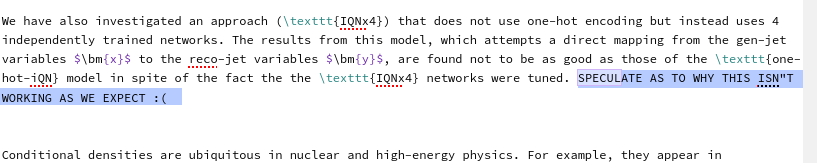

In [35]:
show_jupyter_image('screenshot.png')

> I guess it works now